In [1]:
!nvidia-smi

Wed Mar 31 05:23:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:00:05.0 Off |                  Off |
| N/A   58C    P0    67W / 250W |    721MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import

In [2]:
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from collections import OrderedDict
import csv
import random

import torch
from torch import Tensor
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.models import ResNet
import torchvision.models.resnet as resnet

from adamp import AdamP

from torch.optim import __dict__ as torch_optim_dict
from torch.nn.modules.loss import __dict__ as torch_loss_dict

In [3]:
from typing import Iterable, TypeVar
I = TypeVar('I', np.ndarray, list, int)

In [4]:
np.random.seed(42)
random.seed(42)

# Utilities

In [5]:
##########################################
# UTILITIES ##############################
##########################################

def datetime_str(datetime: datetime, include_date=False, include_time=True, include_decimal=False):
    '''Convert datetime object to str
    '''
    date, time = str(datetime).split()
    time, decimal = time.split('.')
    datetime_str = ''
    if include_date: datetime_str += date
    if include_time: datetime_str += f' {time}'
    if include_decimal: datetime_str += f'.{decimal[:3]}'
    return datetime_str


def time_str(millisecond: float, include_decimal=False):
    r'''Convert time to str
    Args:
        millisecond (float): elapsed time recorded by torch.cuda.Event
        include_decimal (bool): whether include decimal points to second
    '''
    second, decimal = divmod(int(millisecond), 1000)
    minute, second = divmod(second, 60)
    hour, minute = divmod(minute, 60)
    decimal = str(decimal).rjust(3, '0')

    time_str = f'{minute:02d}:{second:02d}'
    if hour > 0:
        time_str = f'{hour}:' + time_str
    # elif minute == 0:
    #   time_str += f'.{decimal}'

    if include_decimal:
        time_str += f'.{decimal}'
    
    return time_str


def empty_logs():
    for log in glob('/opt/ml/output/logs/*.csv'):
        os.remove(log)


def augint(mids, ker):
    if ker == 0:
        return mids
    return np.random.randint(mids - ker, mids + ker, len(mids))


class AttributeDict(dict):
    def __init__(self):
        self.__dict__ = self


class Logger():
    def __init__(self):
        self.train = {'loss': [], 'acc': []}
        self.valid = {'loss': [], 'acc': []}


    def epochs(self):
        if self.train['loss']:
            return self.train['loss'][-1][0]
        else:
            return 0


    def log(self, train, valid):
        self.log_train(*train)
        self.log_valid(*valid)


    def log_train(self, epochs, loss, acc):
        self.train['loss'].append((epochs, loss))
        self.train['acc'].append((epochs, acc))

    
    def log_valid(self, epochs, loss, acc):
        self.valid['loss'].append((epochs, loss))
        self.valid['acc'].append((epochs, acc))


    def get_losses(self):
        return list(zip(self.train['loss'], self.valid['loss']))

    
    def get_accuracies(self):
        return list(zip(self.train['acc'], self.valid['acc']))


    def plot(self, suptitle=None):
        %matplotlib inline

        fig, axes = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)
        
        axes[0].set_title("Loss")
        axes[1].set_title("Accuracy")

        train_color, valid_color = "#ff922b", "#22b8cf"
        
        axes[0].plot(*zip(*self.train["loss"]), c=train_color, label="train")
        axes[0].plot(*zip(*self.valid["loss"]), c=valid_color, label="valid")
        axes[1].plot(*zip(*self.train["acc"]), c=train_color, label="train")
        axes[1].plot(*zip(*self.valid["acc"]), c=valid_color, label="valid")

        for ax in axes:
            ax.legend()
            ax.set_xlabel("epoch")

        if suptitle:
            fig.suptitle(suptitle, fontsize=15)
            fig.tight_layout()

        plt.show()

# Preprocessing

In [6]:
##########################################
# PREPROCESSING ##########################
##########################################


def preprocess(image: np.ndarray, size=256, segment=True, blur=True):
    # Normalize
    image = cv2.normalize(image, 0, 255)

    # Segmentation
    

    # Remove noise - Guassian blur
    if blur:
        image = cv2.GaussianBlur(image, (3, 3), 0)
        # image = cv2.bilateralFilter(image, 5, 75, 75)

    return image

In [7]:
def segment(image: np.ndarray):
    pass

# Augmentation

In [8]:
##########################################
# AUGMENTATION ###########################
##########################################

def affine_random(image, ker=4):
    old = np.float32([[120, 120], [136, 120], [128, 128]])
    new = np.float32([augint(old[0], ker), 
                      augint(old[1], ker),
                      augint(old[2], 0)])
    matrix = cv2.getAffineTransform(old, new)
    image = cv2.warpAffine(image, matrix, image.shape[:2],
                           borderMode=cv2.BORDER_REPLICATE)
    
    return image


def affine(image, num, kernel=(5, 5)):
    if kernel == (0, 0) or kernel == 0:
        return image
    
    if kernel[0] % 2 == 0 or kernel[1] % 2 == 0:
        raise ValueError("Only odd numbers are accepted for kernel size.")
    if np.prod(kernel) <= num:
        raise ValueError(f"Too large num({num}) for kernel({kernel}).")

    decoder = np.zeros(kernel)
    decoder = np.float32(list(zip(*np.where(decoder == 0)))) \
            - np.float32(kernel) // 2
    old = np.float32([[120, 120], [136, 120], [128, 128]])
    new = np.vstack([old[:2] + decoder[num], old[2]])
    matrix = cv2.getAffineTransform(old, new)
    image = cv2.warpAffine(image, matrix, image.shape[:2],
                           borderMode=cv2.BORDER_REPLICATE)
    
    return image


def adjust_contrast(image):
    pass


def crop(image, size):
    height, width = image.shape[:2]
    x_start, x_end = (width - size) // 2, (width + size) // 2
    y_start, y_end = (height - size) // 2, (height + size) // 2
    image = image[x_start:x_end, y_start:y_end]
    image = cv2.resize(image, (height, width))
    image = image / 255.


class RandomAugmenter(object):
    def __init__(self, augs):
        self._augs = self._set_augs(augs)
        self._add_conversion(conv_dict)


    def __call__(self, images):
        if not self._augs:
            return images
            
        num_augs = self.transofrm
        idx = np.random.randint(len(self) + 1)
        if idx == len(self):
            return images
        return _augs[idx](images)


    def __str__(self):
        return self._augs


    def __geitem__(self, idx):
        return self._augs[idx]
        

    def __len__(self):
        return len(self._augs)


    def _set_augs(self, augs):
        transforms_dict = {
            'center_crop':              transforms.CenterCrop,
            'five_crop':                transforms.FiveCrop,
            'ten_crop':                 transforms.TenCrop,
            'random_crop':              transforms.RandomCrop,
            'random_resized_crop':      transforms.RandomResizedCrop,
            'random_rotation':          transforms.RandomRotation,
            'random_affine':            transforms.RandomAffine,
            'random_horizontal_filp':   transforms.RandomHorizontalFlip,
            'random_vertical_flip':     transforms.RandomVerticalFlip,
            'random_perspective':       transforms.RandomPerspective,
            'resize':                   transforms.Resize,
            'color_jitter':             transforms.ColorJitter,
            'grayscale':                transforms.Grayscale,
            'random_graysacle':         transforms.RandomGrayscale,
            'pad':                      transforms.Pad,
            'gaussian_blur':            transforms.GaussianBlur
        }

        aug_dict = {
            'crop': center_crop,
            'random_crop': random_crop,
            'five_crop': five_crop,
            'seg_crop': seg_crop,
            'affine': affine,
            'random_affine': affine_random,
            'brightness': adjust_brightness,
            'rotate': rotate,
            'contrast': adjust_contrast,
        }

        aug_list = []
        for aug in aug_dict.items():
            try: aug_list.append(aug_dict[aug])
            except: continue

        return aug_list


    def add_augs(self, *augs):
        self._augs += augs


    def get_augs(self):
        return self._augs


'''
def get_augmentation(size=256, 
                     use_flip=True, 
                     use_color_jitter=False, 
                     use_gray_scale=False, 
                     use_normalize=False):
    
    resize_crop = transforms.RandomResizedCrop(size=size)
    random_flip = transforms.RandomHorizontalFlip(p=0.5)
    color_jitter = transforms.RandomApply([
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
    ], p=0.8)
    gray_scale = transforms.RandomGrayscale(p=0.2)
    normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    to_tensor = transforms.ToTensor()
    
    transforms_array = np.array([resize_crop, random_flip, color_jitter, gray_scale, to_tensor, normalize])
    transforms_mask = np.array([True, use_flip, use_color_jitter, use_gray_scale, True, use_normalize])
    
    transform = transforms.Compose(transforms_array[transforms_mask])
    
    return transform
'''
print()

# Dataset

In [9]:
##########################################
# DATASET ################################
##########################################   
        

class BasicDataset(Dataset):
    def __init__(self, data: np.ndarray, mode: str, preprocess: bool=True, augment: bool=False):
        self.data = data
#         if mode == 'train':
#             self.data = self.balancing(data)
            
        self.mode = mode
        self.preprocess = preprocess
        self.augment = augment
        
        
    def __getitem__(self, idx: I):
        image_file = self.data[idx]
        image = cv2.imread(image_file)
        
        # debug
        if image is None:
            print(image_file)
            
        h, w, _ = image.shape
        image = image[h-w:, :, :]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.augment: image = affine_random(image, ker=1)
        if self.preprocess: image = preprocess(image)
        image = torch.tensor(image).permute(2, 0, 1).to(torch.float)
        
        image_name = image_file.split('/')[-1]
        if self.mode in ('train', 'valid'):
            label = int(image_name[:2])
            return image, label
        else:
            return image, image_name
    
    
    def __len__(self):
        return len(self.data)
    
    
    def balancing(self, data):
        class_counter = [0] * 18
        for filepath in self.data:
            label = int(filepath.split('/')[-1][:2])
            class_counter[label] += 1
        max_num_class = max(class_counter)
        
        data = []
        for label in range(18):
            data_in_label = [filepath for filepath in self.data if int(filepath.split('/')[-1][:2]) == label]
            num_class = len(data_in_label)
            if num_class < max_num_class:
                data_in_label = np.array(data_in_label)
                random_idx = np.random.randint(0, num_class, max_num_class)
                data_in_label = list(data_in_label[random_idx])

            data += data_in_label
            
        return data
        
        
class AugDataset(BasicDataset):
    def __init__(self, root: os.PathLike, mode: str, num: int, 
                 affine_kernel=(5, 5), gaussian_kernel=(3, 3)):
        super(AugDataset, self).__init__(root, mode)
        self.aug_num = num
        self.affine_kernel = affine_kernel
        self.gaussian_kernel = gaussian_kernel


    def __getitem__(self, idx: I):
        image_file = self.data[idx]
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = affine(image, self.aug_num, self.affine_kernel)
        image = image / 255.
        iamge = cv2.normalize(image, 0, 255)
        image = cv2.GaussianBlur(image, self.gaussian_kernel, 0)
        image = torch.tensor(image).permute(2, 0, 1).to(torch.float)
        
        image_name = image_file.split('/')[-1]
        label = int(image_name[:3])

        return image, label



def train_valid_split(dataset: Dataset, valid_ratio: float=0.2, shuffle: bool=True):
    data_size = len(dataset)
    valid_size = int(data_size * valid_ratio)
    
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    indices_train, indices_valid = indices[valid_size:], indices[:valid_size]
    train, valid = Subset(dataset, indices_train), Subset(dataset, indices_valid)

    return train, valid


def train_valid_raw_split(root: os.PathLike, valid_ratio: float=0.2, shuffle: bool=True):
    raw_data = glob(os.path.join(root, "*.jpg"))
    raw_data = np.array(raw_data)
    
    data_size = len(raw_data)
    valid_size = int(data_size * valid_ratio)
    
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    
    indices_train, indices_valid = indices[valid_size:], indices[:valid_size]
    train, valid = raw_data[indices_train], raw_data[indices_valid]

    return train, valid

# Models

In [10]:
##########################################
# MODELS #################################
##########################################
    
class LPDModel(nn.Module):
    def __init__(self, name='lpd'):
        super(LPDModel, self).__init__()
        self.name = name
        
        
    def init(self):
        self.__init__()
        return self


    def requires_grad(self, mode=True):
        for parameter in self.parameters():
            parameter.requires_grad = mode


    def requires_grad(self, parameters: Iterable[nn.Parameter], mode=True):
        for parameter in parameters:
            parameter.requires_grad = mode

    
    def forward(self, x):
        if x.dim() == 5:
            batch, crop, channel, height, width = x.size()
            x = x.view(-1, channel, height, width)
            outputs = self._forward_impl(x)
            outputs = outputs.view(batch, crop, -1).mean(1)
            return outputs

        return self._forward_impl(x)

    

class ResNetBackbone(ResNet):
    def __init__(self, block, layers):
        super(ResNetBackbone, self).__init__(block, layers)


    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        return x


class PureResNet(LPDModel):
    resnet_urls = {
        'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
        'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
        'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
        'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
        'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
        'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
        'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
        'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
        'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
    }

    resnet_block_layers = {
        'resnet18': (resnet.BasicBlock, [2, 2, 2, 2]),
        'resnet34': (resnet.BasicBlock, [3, 4, 6, 3]),
        'resnet50': (resnet.Bottleneck, [3, 4, 6, 3]),
        'resnet101': (resnet.Bottleneck, [3, 4, 23, 3]),
        'resnet152': (resnet.Bottleneck, [3, 8, 36, 3]),
        'resnetxt50_32x4d': (resnet.Bottleneck, [3, 4, 6, 3]),
        'resnetxt101_32x8d': (resnet.Bottleneck, [3, 4, 23, 3]),
        'wide_resnet50_2': (resnet.Bottleneck, [3, 4, 6, 3]),
        'wide_resnet101_2': (resnet.Bottleneck, [3, 4, 23, 3])
    }

    def __init__(self, pretrained=False, freezed_conv=False, name='resnet18'):
        super(PureResNet, self).__init__()
        self.backbone = ResNetBackbone(*PureResNet.resnet_block_layers[name])
        if pretrained:
            try:
                load_state_dict_from_url = torch.hub.load_state_dict_from_url
            except:
                load_state_dict_from_url = torch.utils.model_zoo.load_url
            state_dict = load_state_dict_from_url(PureResNet.resnet_urls[name], progress=True)
            self.backbone.load_state_dict(state_dict)

        if freezed_conv:
            self.backbone.requires_grad(self.backbone.parameters(), False)

        # """
        # (backbone) ResNetBackbone
        # (classifier) Sequential (inspired from VGG)
        #     [0] Linear(in_features=512, out_features=4096, bias=True)
        #     [1] ReLU(inplace=True)
        #     [2] Dropout(p=0.5, inplace=False)
        #     [3] Linear(in_features=4096, out_features=4096, bias=True)
        #     [4] ReLU(inplace=True)
        #     [5] Dropout(p=0.5, inplace=False)
        #     [6] Linear(in_features=4096, out_features=1000, bias=True)
        # """
        # self.classifier = nn.Sequential(OrderedDict([
        #     ('fc1', nn.Linear(in_features=512, out_features=4096, bias=True)),
        #     ('relu1', nn.ReLU(inplace=True)),
        #     ('dout1', nn.Dropout(p=0.5, inplace=False)),
        #     ('fc2', nn.Linear(in_features=4096, out_features=4096, bias=True)),
        #     ('relu2', nn.ReLU(inplace=True)),
        #     ('dout2', nn.Dropout(p=0.5, inplace=False)),
        #     ('fc3', nn.Linear(in_features=4096, out_features=1000, bias=True))
        # ]))

        self.classifier = nn.Linear(self.backbone.fc.in_features, 1000, bias=True)
        self.name = name

        
    def _forward_impl(self, x):
        x = self.backbone(x)
        x = self.classifier(x)

        return x


class SimplerConvNet(LPDModel):
    def __init__(self, name='simple_conv'):
        super().__init__(name)
        self.conv1 = nn.Conv2d(3, 256, kernel_size=(7, 7), stride=3, padding=3)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(256, 256, 3, 1, 0)
        self.bn2 = nn.BatchNorm2d(256)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1000)


    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
        

class PretrainedResNet(LPDModel):
    def __init__(self, state_dict, name='resnet_pretrained'):
        super(PretrainedResNet, self).__init__()
        self.pretrain_extractor = torchvision.models.resnet50(pretrained=True)

        self.pretrain_extractor.fc = nn.Sequential(
            nn.Linear(self.pretrain_extractor.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2)
        )
        self.load_state_dict(state_dict)
        
        self.pretrain_extractor.fc[3] = nn.Linear(512, 1000)
        
        self.requires_grad(True)


    def forward(self, x):
        return self.pretrain_extractor(x)


# Configuration Tree

In [11]:
##########################################
# CONFIGURATION ##########################
##########################################


class ConfigBranch(dict):
    def __init__(self, **kwarg):
        self.__dict__ = self
        self.assign(**kwarg)
            
    
    def __call__(self, **kwarg):
        self.assign(**kwarg)
        return self.__dict__


    def __bool__(self):
        return self.__dict__


    def assign(self, **kwarg):
        for name, attr in kwarg.items():
            setattr(self, name, attr)
        return kwarg
    
    
class ConfigTree():
    def __init__(self):
        self.system = ConfigBranch()
        self.path = ConfigBranch()
        self.data = ConfigBranch()
        self.model = ConfigBranch()
        self.train = ConfigBranch()
        self.test = ConfigBranch()

    
    def __bool__(self):
        return any(self.__dict__.values())


# Trainer

In [12]:
##########################################
# TRAINER ################################
##########################################


class Trainer():
    def __init__(self, config: ConfigTree):
        self.config = config
        self.configure()
        
        self.train_loader, self.valid_loader = self._train_valid_shuffle()

        test_set = BasicDataset(
            glob(os.path.join(self.config.path.test, '*.jpg')), 
            mode='test', 
            preprocess=True, 
            augment=False
        )
        self.test_loader = self._data_loader(test_set, False)

        self.criterion = torch_loss_dict[self.config.train.loss.criterion]()
        
        self.logger = config.train.logger
        self.log_files = [os.path.join(self.config.path.logs, self.model.name + '_train_loss.csv'),
                          os.path.join(self.config.path.logs, self.model.name + '_train_acc.csv'),
                          os.path.join(self.config.path.logs, self.model.name + '_valid_loss.csv'),
                          os.path.join(self.config.path.logs, self.model.name + '_valid_acc.csv')]
        
        self.epochs = 0
        self.load_logs()
        

    def _train_valid_shuffle(self):
#         train_set, valid_set = train_valid_split(
#             # dataset=AugDataset(self.train_data, num=0, affine_kernel=self.config.data.affine_kernel),
#             dataset=BasicDataset(self.config.path.train, labeled=True, preprocess=True, augment=False),
#             valid_ratio=self.config.data.valid_ratio, 
#             shuffle=True
#         )

        train_data, valid_data = train_valid_raw_split(
            self.config.path.train
        )
        train_set = BasicDataset(train_data, mode='train', preprocess=True, augment=False)
        valid_set = BasicDataset(valid_data, mode='valid', preprocess=True, augment=False)
        
        return self._data_loader(train_set, True), self._data_loader(valid_set, False)


    def _data_loader(self, dataset, shuffle):
        return DataLoader(dataset, batch_size=self.config.data.batch_size,
                          shuffle=shuffle, num_workers=self.num_workers)


    def configure(self):
        self.device = self.config.system.device
        self.num_workers = self.config.system.num_workers
        
        self.model = self.config.model.model.to(self.device)
        params_backbone, params_classifier = [], []
        for module in self.model.children():
            if module == self.model.fc:
                params_classifier += list(module.parameters())
            else:
                params_backbone += list(module.parameters())
        
        if self.config.train.lr.backbone != self.config.train.lr.classifier:
            self.lr = {
                'backbone': self.config.train.lr.backbone,
                'classifier': self.config.train.lr.classifier
            }
            if self.config.model.optimizer.lower() == 'adamp':
                self.optimizer_backbone = AdamP(
                    [param for param in params_backbone if param.requires_grad],
                    lr=self.lr['backbone'],
                    betas=self.config.train.betas, 
                    weight_decay=self.config.train.weight_decay
                )
                self.optimizer_classifier = AdamP(
                    [param for param in params_classifier if param.requires_grad],
                    lr=self.lr['classifier'],
                    betas=self.config.train.betas, 
                    weight_decay=self.config.train.weight_decay
                )
            else:
                self.optimizer_backbone = torch_optim_dict[self.config.model.optimizer](
                    [param for param in params_backbone if param.requires_grad],
                    lr=self.config.train.lr.backbone,
                    weight_decay=self.config.train.weight_decay
                )
                self.optimizer_classifier = torch_optim_dict[self.config.model.optimizer](
                    [param for param in params_classifier if param.requires_grad],
                    lr=self.config.train.lr.classifier,
                    weight_decay=self.config.train.weight_decay
                )
        else:
            self.lr = self.config.train.lr.base
            if self.config.model.optimizer.lower() == 'adamp':
                self.optimizer = AdamP(
                    [param for param in self.model.parameters() if param.requires_grad],
                    lr=self.config.train.lr.base, 
                    betas=self.config.train.betas, 
                    weight_decay=self.config.train.weight_decay
                )
            else:
                self.optimizer = torch_optim_dict[self.config.model.optimizer](
                    [param for param in self.model.parameters() if param.requires_grad],
                    lr=self.config.train.lr.base,
                    weight_decay=self.config.train.weight_decay
                )
     

    def load_logs(self):
        dests = [self.logger.train['loss'], self.logger.train['acc'],
                 self.logger.valid['loss'], self.logger.valid['acc']]
        for i in range(4):
            if not os.path.exists(self.log_files[i]):
                continue

            with open(self.log_files[i], newline='') as csvfile:
                reader = csv.reader(csvfile)
                for epochs, value in reader:
                    dests[i].append((int(epochs), float(value)))

            if i == 0:
                self.epochs = int(epochs)


    def write_log(self, dest: str, *values):
        with open(dest, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(values)

        
    def train_and_save(self):
        self.configure()

        print(f"[INFO] device={self.device}({torch.cuda.get_device_name(self.device)}), \
model={self.model.name}, epochs={self.config.train.num_epochs}")
        print(f"       lr={self.lr}, batch_size={self.config.data.batch_size}, \
optim={self.config.model.optimizer}")
        print()
        print(f"Start of traning.")


        def save_with_name():
            # config_mode="json" with function to convert ConfigTree to JSON
            try:
                self.save(self.model.name, config_mode=None)
            except AttributeError:
                self.save(config_mode=None)


        last_train_loss = 0
        last_train_score = 0
        last_valid_loss = 0
        last_valid_score = 0
        for _ in range(self.config.train.num_epochs):
            if self.config.train.valid_min == 0:
                valid_loss, valid_score = self.valid()
                last_valid_score = valid_score
            
            self.epochs += 1
            
            train_loss, train_score = self.train_one_epoch()
            last_train_loss, last_train_score = train_loss, train_score

            # k-fold validation
            if self.config.train.shuffle_period > 0 \
            and self.epochs % self.config.train.shuffle_period == 0:
                self.train_loader, self.valid_loader = self._train_valid_shuffle()

            if self.config.train.valid_period > 0 \
            and self.epochs >= self.config.train.valid_min \
            and self.epochs % self.config.train.valid_period == 0:
                valid_loss, valid_score = self.valid()
                last_valid_score = valid_score
            
            # save state
            if self.config.train.save_period > 0 \
            and self.epochs >= self.config.train.save_min \
            and self.epochs % self.config.train.save_period == 0 \
            and last_valid_score >= self.config.train.save_min_acc:
                save_with_name()
            
            # test
            if self.config.train.test_period > 0 \
            and self.epochs >= self.config.train.test_min \
            and self.epochs % self.config.train.test_period == 0 \
            and last_valid_score >= self.config.train.test_min_acc:
                self.infer_test_and_save()

            # plot loss & acc
            if self.config.train.plot_period > 0 \
            and self.config.train.plot_period > 0 \
            and self.epochs % self.config.train.plot_period == 0:
                self.logger.plot()
        
        self.valid()
        save_with_name()

        print()
        print("End of training.")
        print()
        
        
    def train_one_epoch(self, add_loader=None):
        print(f"[Epoch {self.epochs:03d}]", end="")
        
        self.model.train()
        
        starter = torch.cuda.Event(enable_timing=True)
        ender = torch.cuda.Event(enable_timing=True)
        
        starter.record()
        
        data_loader = add_loader if add_loader else self.train_loader
        epoch_time = train_loss = 0
        correct = total = 0
        for batch, (inputs, targets) in enumerate(data_loader):
            inputs = inputs.to(self.device)
            
            if self.config.train.lr.backbone != self.config.train.lr.classifier:
                self.optimizer_backbone.zero_grad()
                self.optimizer_classifier.zero_grad()
            else:
                self.optimizer.zero_grad()
            
            outputs = self.model(inputs)
            targets = targets.to(self.device)

            loss = self.criterion(outputs, targets)
            loss.backward()
            if self.config.train.lr.backbone != self.config.train.lr.classifier:
                self.optimizer_backbone.step()
                self.optimizer_classifier.step()
            else:
                self.optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            total += targets.shape[0]
            correct += predicted.eq(targets).sum().item()

            ender.record()
            torch.cuda.synchronize()
            
            batch_time = starter.elapsed_time(ender) - epoch_time
            epoch_time += batch_time
            
            print(f'\r[Epoch {self.epochs:03d}] (Batch #{batch:03d})  \
Loss: {train_loss / (batch + 1):.5f},  Acc: {correct / total * 100:.3f}  \
({time_str(epoch_time)})', end='')
            
        print()

        train_loss /= batch + 1
        accuracy  = correct / total
        
        self.logger.log_train(self.epochs, train_loss, accuracy)
        self.write_log(self.log_files[0], self.epochs, train_loss)
        self.write_log(self.log_files[1], self.epochs, accuracy)

        return train_loss, accuracy
        
        
    def valid(self):
        self.configure()

        valid_num = (self.epochs - self.config.train.valid_min + 1)\
         // self.config.train.valid_period if self.epochs > 0 else self.epochs
        print(f"[Valid {valid_num:03d}] ", end=" ")
        
        self.model.eval()
        
        valid_loss = 0
        correct = total = 0
        with torch.no_grad():
            for batch, (inputs, targets) in enumerate(self.valid_loader):
                if self.config.train.valid_iters > 0 and batch >= self.config.train.valid_iters:
                    break
                    
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                valid_loss += loss.item()
                predictions = torch.argmax(outputs, dim=1)

                total += targets.shape[0]
                correct += predictions.eq(targets).sum().item()

                print(f'\r[Valid {valid_num:03d}] (Batch #{batch:03d})  \
Loss: {valid_loss / (batch + 1):.5f},  Acc: {correct / total * 100:.3f}', end='')

        print()
        valid_loss /= batch + 1
        accuracy = correct / total
        
        self.logger.log_valid(self.epochs, valid_loss, accuracy)
        self.write_log(self.log_files[2], self.epochs, valid_loss)
        self.write_log(self.log_files[3], self.epochs, accuracy)

        return valid_loss, accuracy
        
        
    def save(self, name='', postfix=None, config_mode=None):
        file_name = f'{datetime.today()}_{name}_{postfix if postfix else ""}'
        
        # save model parameter
        model_output = os.path.join(self.config.path.models, file_name + ".pth")
        torch.save(self.model.state_dict(), model_output)
        print(f"Saved model: {model_output}")

        # save configurations
        if config_mode == "json":
            config_output = os.path.join(self.config.path.configs, file_name + ".json")
            with open(config_output, "w") as f:
                json.dump(self.config, f)
                
                
    def infer_test_and_save(self):
        self.configure()
        starter = torch.cuda.Event(enable_timing=True)
        ender   = torch.cuda.Event(enable_timing=True)
        starter.record()

        self.model.eval()
        indices = [path.split('/')[-1] for path in glob(os.path.join(self.config.path.test, '*.jpg'))]
        result = pd.DataFrame(columns=['ans'], index=indices)
        result.index.name = 'ImageID'
        
        with torch.no_grad():
            for i, (inputs, filenames) in enumerate(self.test_loader):
                inputs = inputs.to(self.device)
                filenames = np.array(filenames)

                outputs = self.model(inputs)
                predictions = torch.argmax(outputs, dim=1).cpu()

                result['ans'][filenames] = predictions

                ender.record()
                torch.cuda.synchronize()
                infer_time = starter.elapsed_time(ender)
                
                print(f"\rEvaluating: batch #{i} ({time_str(infer_time)})", end="")
        
        csv_name = f"{datetime.today()}.csv"
        csv_path = os.path.join(self.config.path.output, csv_name)
        result.to_csv(csv_path)
        
        print(f"\rSaved result: {csv_path}")

# Main

## Configurations

In [13]:
##########################################
# MAIN: CONFIGURATIONS ###################
##########################################

# new model
model = torchvision.models.resnet18(True)
setattr(model, 'name', 'resnet18_cl18-tlp')

In [14]:
# new config
config = ConfigTree()

In [15]:
# device
config.system.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config.system.num_workers = 1

# path
config.path.base = os.path.join('/', 'opt', 'ml', 'input', 'data')
config.path.train = os.path.join(config.path.base, 'train', 'images', '_all')
config.path.test = os.path.join(config.path.base, 'eval', 'images')

config.path.output = os.path.join('/', 'opt', 'ml', 'output')
config.path.models = os.path.join(config.path.output, 'models')
config.path.configs = os.path.join(config.path.output, 'configs')
config.path.logs = os.path.join(config.path.output, 'logs')

# data
config.data.valid_ratio = 0.15
config.data.batch_size = 128

config.data.affine_kernel = (5, 5)

# train hyperparameters
config.train.lr = ConfigBranch(base=5e-6, backbone=0, classifier=0)
config.train.weight_decay = 1
config.train.loss = ConfigBranch(
    criterion='CrossEntropyLoss'
)

# train monitor settings
config.train.num_epochs = 25
config.train.valid_iters = 0

config.train.valid_min = 1
config.train.test_min = 1
config.train.save_min = 1

config.train.valid_period = 1
config.train.test_period = 0
config.train.save_period = 1
config.train.shuffle_period = 0
config.train.plot_period = 5

config.train.valid_min_acc = 0
config.train.test_min_acc = 0.5
config.train.save_min_acc = 0

config.train.logger = Logger()

In [16]:
# model
config.model = ConfigBranch()
config.model.model = model
config.model.continue_after = '/opt/ml/input/pretrained/resnet18-f37072fd.pth'
config.model.optimizer = 'Adam'
config.train.betas=(0.9, 0.99)

## Execution

In [17]:
##########################################
# MAIN: EXECUTION ########################
##########################################

# new trainer
trainer = Trainer(config)

In [18]:
if config.model.continue_after:
    trainer.model.load_state_dict(torch.load(
        config.model.continue_after,
        map_location=config.system.device
    ))
    
    indices = np.random.randint(0, trainer.model.fc.out_features, 18)
    trainer.model.fc.weight = nn.Parameter(trainer.model.fc.weight[indices])
    trainer.model.fc.bias = nn.Parameter(trainer.model.fc.bias[indices])
    trainer.model.out_features = 18

NameError: name 'trianer' is not defined

In [21]:
# train model
trainer.train_and_save()

[INFO] device=cuda:0(Tesla P40), model=resnet18_cl18-tlp, epochs=25
       lr=5e-06, batch_size=128, optim=Adam

Start of traning.
[Epoch 078] (Batch #118)  Loss: 1.99292,  Acc: 40.093  (01:24)
[Valid 078] (Batch #029)  Loss: 2.02347,  Acc: 39.841
Saved model: /opt/ml/output/models/2021-03-31 05:45:53.040900_resnet18_cl18-tlp_.pth
[Epoch 079] (Batch #109)  Loss: 1.93411,  Acc: 41.548  (01:18)

KeyboardInterrupt: 

[INFO] device=cuda:0(Tesla P40), model=resnet18_cl18-tlp, epochs=50
       lr=5e-06, batch_size=128, optim=Adam

Start of traning.
[Epoch 006] (Batch #118)  Loss: 6.64640,  Acc: 3.558  (01:23)
[Valid 006] (Batch #029)  Loss: 6.40801,  Acc: 5.767
[Epoch 007] (Batch #118)  Loss: 6.27683,  Acc: 7.427  (01:23)
[Valid 007] (Batch #029)  Loss: 5.97828,  Acc: 11.296
[Epoch 008] (Batch #118)  Loss: 5.88879,  Acc: 12.434  (01:23)
[Valid 008] (Batch #029)  Loss: 5.64521,  Acc: 16.402
[Epoch 009] (Batch #118)  Loss: 5.50612,  Acc: 18.757  (01:23)
[Valid 009] (Batch #029)  Loss: 5.33302,  Acc: 21.005
[Epoch 010] (Batch #118)  Loss: 5.12889,  Acc: 25.086  (01:23)
[Valid 010] (Batch #029)  Loss: 4.85198,  Acc: 28.704


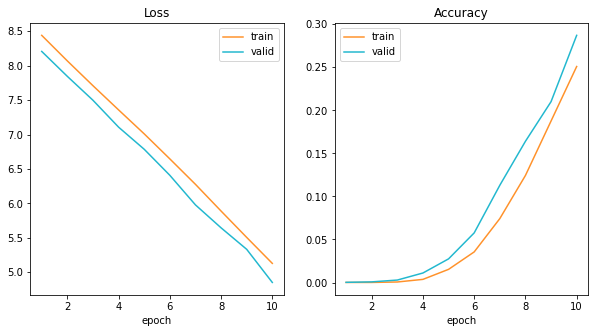

[Epoch 011] (Batch #118)  Loss: 4.75529,  Acc: 29.960  (01:23)
[Valid 011] (Batch #029)  Loss: 4.55678,  Acc: 32.989
[Epoch 012] (Batch #118)  Loss: 4.40079,  Acc: 34.187  (01:23)
[Valid 012] (Batch #029)  Loss: 4.27181,  Acc: 36.085
[Epoch 013] (Batch #118)  Loss: 4.06102,  Acc: 38.049  (01:23)
[Valid 013] (Batch #029)  Loss: 3.92872,  Acc: 39.683
[Epoch 014] (Batch #118)  Loss: 3.72946,  Acc: 41.409  (01:23)
[Valid 014] (Batch #029)  Loss: 3.64004,  Acc: 42.354
[Epoch 015] (Batch #118)  Loss: 3.42982,  Acc: 44.292  (01:23)
[Valid 015] (Batch #029)  Loss: 3.35194,  Acc: 44.921


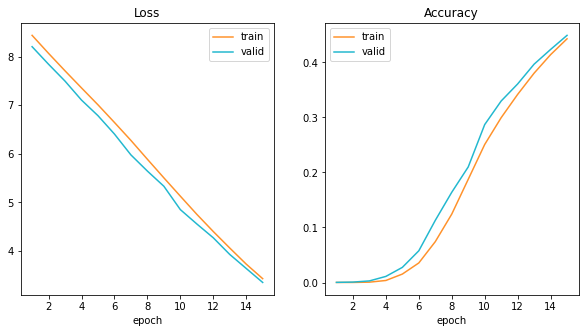

[Epoch 016] (Batch #118)  Loss: 3.15077,  Acc: 46.640  (01:23)
[Valid 016] (Batch #029)  Loss: 3.09072,  Acc: 46.561
[Epoch 017] (Batch #118)  Loss: 2.91608,  Acc: 48.591  (01:23)
[Valid 017] (Batch #029)  Loss: 2.91086,  Acc: 48.201
[Epoch 018] (Batch #118)  Loss: 2.70630,  Acc: 50.317  (01:23)
[Valid 018] (Batch #029)  Loss: 2.70355,  Acc: 49.471
[Epoch 019] (Batch #118)  Loss: 2.51448,  Acc: 51.772  (01:23)
[Valid 019] (Batch #014)  Loss: 2.53476,  Acc: 50.000

KeyboardInterrupt: 

In [48]:
config.train.num_epochs = 50
trainer.train_and_save()

In [50]:
trainer.valid()
trainer.save()

[Valid 019] (Batch #029)  Loss: 2.51913,  Acc: 50.503
Saved model: /opt/ml/output/models/2021-03-31 03:07:52.029292__.pth


[INFO] device=cuda:0(Tesla P40), model=resnet18_cl18-tlp, epochs=25
       lr=5e-06, batch_size=128, optim=Adam

Start of traning.
[Epoch 020] (Batch #118)  Loss: 2.35524,  Acc: 53.175  (01:23)
[Valid 020] (Batch #029)  Loss: 2.39037,  Acc: 51.825
Saved model: /opt/ml/output/models/2021-03-31 03:09:38.777264_resnet18_cl18-tlp_.pth


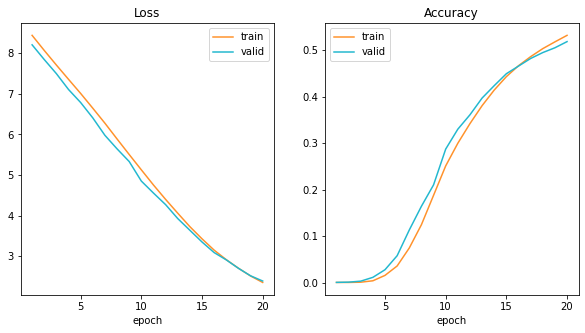

[Epoch 021] (Batch #118)  Loss: 2.22007,  Acc: 54.306  (01:23)
[Valid 021] (Batch #029)  Loss: 2.26507,  Acc: 52.513
Saved model: /opt/ml/output/models/2021-03-31 03:11:21.905361_resnet18_cl18-tlp_.pth
[Epoch 022] (Batch #118)  Loss: 2.09300,  Acc: 55.496  (01:23)
[Valid 022] (Batch #029)  Loss: 2.17292,  Acc: 53.095
Saved model: /opt/ml/output/models/2021-03-31 03:13:04.899839_resnet18_cl18-tlp_.pth
[Epoch 023] (Batch #118)  Loss: 1.97803,  Acc: 56.832  (01:23)
[Valid 023] (Batch #029)  Loss: 2.03403,  Acc: 54.444
Saved model: /opt/ml/output/models/2021-03-31 03:14:47.188316_resnet18_cl18-tlp_.pth
[Epoch 024] (Batch #118)  Loss: 1.88958,  Acc: 57.738  (01:23)
[Valid 024] (Batch #029)  Loss: 1.97407,  Acc: 54.815
Saved model: /opt/ml/output/models/2021-03-31 03:16:29.396364_resnet18_cl18-tlp_.pth
[Epoch 025] (Batch #118)  Loss: 1.79635,  Acc: 58.763  (01:23)
[Valid 025] (Batch #029)  Loss: 1.88605,  Acc: 55.873
Saved model: /opt/ml/output/models/2021-03-31 03:18:11.576138_resnet18_cl18

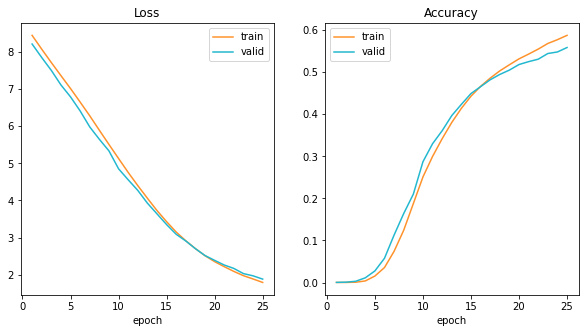

[Epoch 026] (Batch #118)  Loss: 1.71035,  Acc: 60.046  (01:23)
[Valid 026] (Batch #029)  Loss: 1.81819,  Acc: 56.243
Saved model: /opt/ml/output/models/2021-03-31 03:19:54.338062_resnet18_cl18-tlp_.pth
[Epoch 027] (Batch #118)  Loss: 1.65085,  Acc: 60.489  (01:23)
[Valid 027] (Batch #029)  Loss: 1.72921,  Acc: 57.090
Saved model: /opt/ml/output/models/2021-03-31 03:21:36.331926_resnet18_cl18-tlp_.pth
[Epoch 028] (Batch #118)  Loss: 1.58091,  Acc: 61.812  (01:23)
[Valid 028] (Batch #029)  Loss: 1.69050,  Acc: 57.963
Saved model: /opt/ml/output/models/2021-03-31 03:23:18.497164_resnet18_cl18-tlp_.pth
[Epoch 029] (Batch #118)  Loss: 1.51057,  Acc: 63.128  (01:23)
[Valid 029] (Batch #029)  Loss: 1.61927,  Acc: 59.312
Saved model: /opt/ml/output/models/2021-03-31 03:25:00.138534_resnet18_cl18-tlp_.pth
[Epoch 030] (Batch #118)  Loss: 1.45450,  Acc: 64.001  (01:23)
[Valid 030] (Batch #029)  Loss: 1.59286,  Acc: 59.630
Saved model: /opt/ml/output/models/2021-03-31 03:26:42.200225_resnet18_cl18

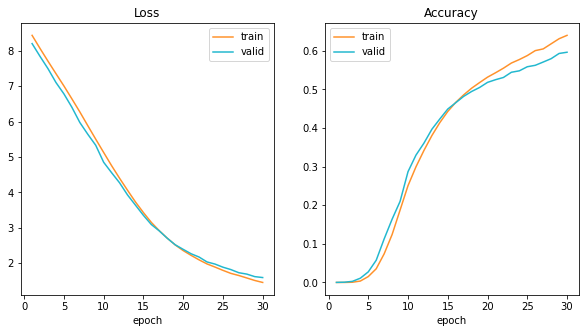

[Epoch 031] (Batch #118)  Loss: 1.41363,  Acc: 64.696  (01:23)
[Valid 031] (Batch #029)  Loss: 1.54850,  Acc: 60.556
Saved model: /opt/ml/output/models/2021-03-31 03:28:24.544667_resnet18_cl18-tlp_.pth
[Epoch 032] (Batch #118)  Loss: 1.35646,  Acc: 66.038  (01:23)
[Valid 032] (Batch #029)  Loss: 1.48888,  Acc: 61.164
Saved model: /opt/ml/output/models/2021-03-31 03:30:06.501859_resnet18_cl18-tlp_.pth
[Epoch 033] (Batch #118)  Loss: 1.30705,  Acc: 66.845  (01:23)
[Valid 033] (Batch #029)  Loss: 1.45940,  Acc: 61.296
Saved model: /opt/ml/output/models/2021-03-31 03:31:49.552825_resnet18_cl18-tlp_.pth
[Epoch 034] (Batch #118)  Loss: 1.25851,  Acc: 68.029  (01:23)
[Valid 034] (Batch #029)  Loss: 1.41624,  Acc: 61.455
Saved model: /opt/ml/output/models/2021-03-31 03:33:32.304548_resnet18_cl18-tlp_.pth
[Epoch 035] (Batch #118)  Loss: 1.21384,  Acc: 69.028  (01:23)
[Valid 035] (Batch #029)  Loss: 1.40833,  Acc: 62.037
Saved model: /opt/ml/output/models/2021-03-31 03:35:15.117867_resnet18_cl18

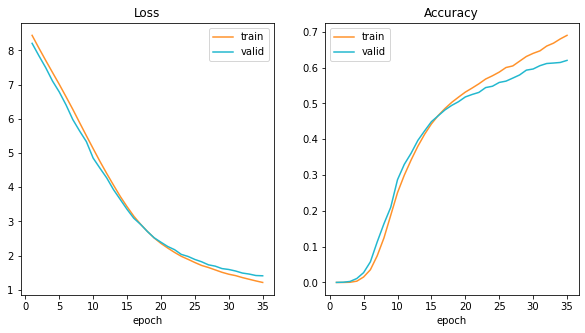

[Epoch 036] (Batch #118)  Loss: 1.16700,  Acc: 70.324  (01:23)
[Valid 036] (Batch #029)  Loss: 1.36623,  Acc: 63.836
Saved model: /opt/ml/output/models/2021-03-31 03:36:57.043350_resnet18_cl18-tlp_.pth
[Epoch 037] (Batch #118)  Loss: 1.12893,  Acc: 71.224  (01:23)
[Valid 037] (Batch #029)  Loss: 1.35172,  Acc: 63.545
Saved model: /opt/ml/output/models/2021-03-31 03:38:39.595943_resnet18_cl18-tlp_.pth
[Epoch 038] (Batch #118)  Loss: 1.08294,  Acc: 72.275  (01:23)
[Valid 038] (Batch #029)  Loss: 1.30838,  Acc: 64.392
Saved model: /opt/ml/output/models/2021-03-31 03:40:21.469318_resnet18_cl18-tlp_.pth
[Epoch 039] (Batch #118)  Loss: 1.03355,  Acc: 73.717  (01:23)
[Valid 039] (Batch #029)  Loss: 1.26539,  Acc: 65.159
Saved model: /opt/ml/output/models/2021-03-31 03:42:04.292997_resnet18_cl18-tlp_.pth
[Epoch 040] (Batch #118)  Loss: 0.98883,  Acc: 74.511  (01:23)
[Valid 040] (Batch #029)  Loss: 1.26002,  Acc: 65.238
Saved model: /opt/ml/output/models/2021-03-31 03:43:45.632484_resnet18_cl18

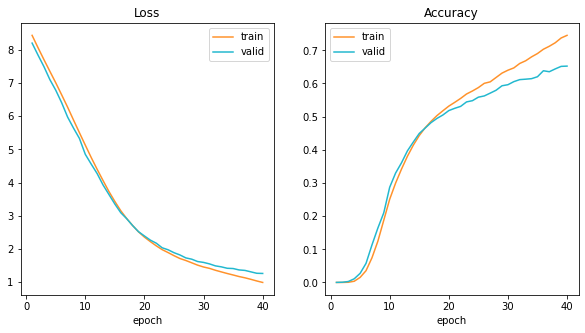

[Epoch 041] (Batch #118)  Loss: 0.94899,  Acc: 75.886  (01:23)
[Valid 041] (Batch #029)  Loss: 1.24640,  Acc: 65.767
Saved model: /opt/ml/output/models/2021-03-31 03:45:27.733170_resnet18_cl18-tlp_.pth
[Epoch 042] (Batch #118)  Loss: 0.91543,  Acc: 76.991  (01:23)
[Valid 042] (Batch #029)  Loss: 1.21450,  Acc: 66.190
Saved model: /opt/ml/output/models/2021-03-31 03:47:09.827275_resnet18_cl18-tlp_.pth
[Epoch 043] (Batch #118)  Loss: 0.87671,  Acc: 78.380  (01:23)
[Valid 043] (Batch #029)  Loss: 1.21854,  Acc: 65.820
Saved model: /opt/ml/output/models/2021-03-31 03:48:51.627560_resnet18_cl18-tlp_.pth
[Epoch 044] (Batch #118)  Loss: 0.82315,  Acc: 79.630  (01:23)
[Valid 044] (Batch #029)  Loss: 1.19393,  Acc: 65.847
Saved model: /opt/ml/output/models/2021-03-31 03:50:33.228564_resnet18_cl18-tlp_.pth
[Valid 044] (Batch #029)  Loss: 1.19393,  Acc: 65.847
Saved model: /opt/ml/output/models/2021-03-31 03:50:51.656256_resnet18_cl18-tlp_.pth

End of training.



In [51]:
trainer.train_and_save()

[INFO] device=cuda:0(Tesla P40), model=resnet18_cl18-tlp, epochs=25
       lr=1e-06, batch_size=128, optim=Adam

Start of traning.
[Epoch 045] (Batch #118)  Loss: 0.75263,  Acc: 82.189  (01:23)
[Valid 045] (Batch #029)  Loss: 1.17699,  Acc: 66.296
Saved model: /opt/ml/output/models/2021-03-31 04:04:30.050885_resnet18_cl18-tlp_.pth


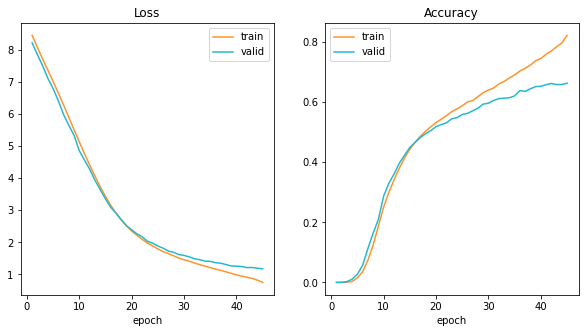

[Epoch 046] (Batch #118)  Loss: 0.74092,  Acc: 82.361  (01:23)
[Valid 046] (Batch #029)  Loss: 1.18313,  Acc: 67.222
Saved model: /opt/ml/output/models/2021-03-31 04:06:12.146092_resnet18_cl18-tlp_.pth
[Epoch 047] (Batch #118)  Loss: 0.73520,  Acc: 82.864  (01:23)
[Valid 047] (Batch #029)  Loss: 1.17790,  Acc: 66.984
Saved model: /opt/ml/output/models/2021-03-31 04:07:53.696683_resnet18_cl18-tlp_.pth
[Epoch 048] (Batch #118)  Loss: 0.72189,  Acc: 83.108  (01:23)
[Valid 048] (Batch #029)  Loss: 1.17680,  Acc: 67.063
Saved model: /opt/ml/output/models/2021-03-31 04:09:36.579322_resnet18_cl18-tlp_.pth
[Epoch 049] (Batch #118)  Loss: 0.72114,  Acc: 83.294  (01:23)
[Valid 049] (Batch #029)  Loss: 1.18082,  Acc: 67.011
Saved model: /opt/ml/output/models/2021-03-31 04:11:18.476995_resnet18_cl18-tlp_.pth
[Epoch 050] (Batch #118)  Loss: 0.71310,  Acc: 83.466  (01:23)
[Valid 050] (Batch #029)  Loss: 1.18127,  Acc: 66.746
Saved model: /opt/ml/output/models/2021-03-31 04:13:00.280339_resnet18_cl18

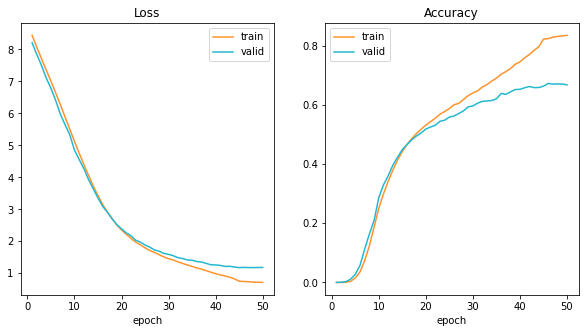

[Epoch 051] (Batch #118)  Loss: 0.69660,  Acc: 83.657  (01:23)
[Valid 051] (Batch #029)  Loss: 1.17030,  Acc: 67.037
Saved model: /opt/ml/output/models/2021-03-31 04:14:42.004922_resnet18_cl18-tlp_.pth
[Epoch 052] (Batch #068)  Loss: 0.69694,  Acc: 83.967  (00:48)

KeyboardInterrupt: 

In [53]:
config.train.lr.base = 1e-6
trainer.train_and_save()

[INFO] device=cuda:0(Tesla P40), model=resnet18_cl18-tlp, epochs=25
       lr=1e-07, batch_size=128, optim=Adam

Start of traning.
[Epoch 049] (Batch #118)  Loss: 0.70742,  Acc: 83.902  (01:23)
[Valid 049] (Batch #029)  Loss: 1.16563,  Acc: 67.143
Saved model: /opt/ml/output/models/2021-03-31 04:18:23.890569_resnet18_cl18-tlp_.pth
[Epoch 050] (Batch #118)  Loss: 0.70601,  Acc: 83.664  (01:23)
[Valid 050] (Batch #029)  Loss: 1.17212,  Acc: 67.169
Saved model: /opt/ml/output/models/2021-03-31 04:20:06.269338_resnet18_cl18-tlp_.pth


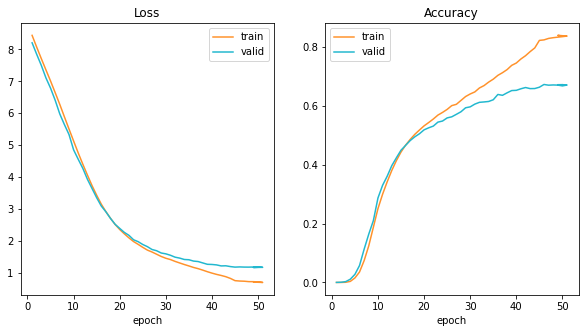

[Epoch 051] (Batch #118)  Loss: 0.70421,  Acc: 83.585  (01:23)
[Valid 051] (Batch #029)  Loss: 1.18135,  Acc: 66.772
Saved model: /opt/ml/output/models/2021-03-31 04:21:48.230300_resnet18_cl18-tlp_.pth
[Epoch 052] (Batch #064)  Loss: 0.70141,  Acc: 83.582  (00:46)

KeyboardInterrupt: 

In [54]:
trainer.model.load_state_dict(torch.load(
    '/opt/ml/output/models/2021-03-31 04:09:36.579322_resnet18_cl18-tlp_.pth',
    map_location=config.system.device
))
config.train.lr.base = 1e-7
trainer.epochs = 48
trainer.train_and_save()

In [55]:
trainer.model.load_state_dict(torch.load(
    '/opt/ml/output/models/2021-03-31 04:09:36.579322_resnet18_cl18-tlp_.pth',
    map_location=config.system.device
))

config.train.lr.base = 5e-6
trainer.epochs = 48

for _ in range(10):
    trainer.epochs += 1
    trainer.train_one_epoch(trainer.valid_loader)
    trainer.save()

[Epoch 049] (Batch #029)  Loss: 1.20848,  Acc: 66.164  (00:21)
Saved model: /opt/ml/output/models/2021-03-31 04:23:14.053124__.pth
[Epoch 050] (Batch #029)  Loss: 1.19975,  Acc: 66.534  (00:21)
Saved model: /opt/ml/output/models/2021-03-31 04:23:35.641516__.pth
[Epoch 051] (Batch #029)  Loss: 1.19230,  Acc: 66.852  (00:21)
Saved model: /opt/ml/output/models/2021-03-31 04:23:57.246089__.pth
[Epoch 052] (Batch #029)  Loss: 1.18581,  Acc: 66.931  (00:21)
Saved model: /opt/ml/output/models/2021-03-31 04:24:19.004840__.pth
[Epoch 053] (Batch #029)  Loss: 1.17990,  Acc: 67.090  (00:21)
Saved model: /opt/ml/output/models/2021-03-31 04:24:40.692050__.pth
[Epoch 054] (Batch #029)  Loss: 1.17437,  Acc: 67.116  (00:21)
Saved model: /opt/ml/output/models/2021-03-31 04:25:02.369967__.pth
[Epoch 055] (Batch #029)  Loss: 1.16912,  Acc: 67.328  (00:21)
Saved model: /opt/ml/output/models/2021-03-31 04:25:24.073950__.pth
[Epoch 056] (Batch #029)  Loss: 1.16409,  Acc: 67.354  (00:21)
Saved model: /opt/ml

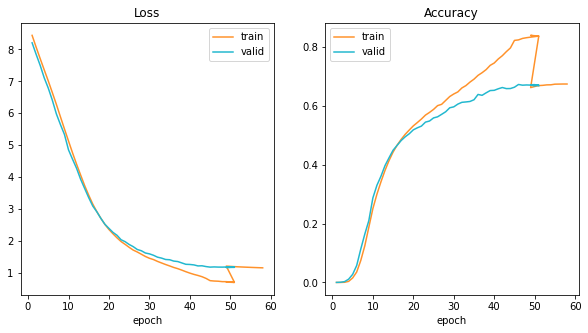

In [57]:
trainer.logger.plot()

In [58]:
trainer.model.load_state_dict(torch.load(
    '/opt/ml/output/models/2021-03-31 04:09:36.579322_resnet18_cl18-tlp_.pth',
    map_location=config.system.device
))

trainer.infer_test_and_save()

Saved result: /opt/ml/output/2021-03-31 04:27:59.450420.csv


In [59]:
trainer.model.load_state_dict(torch.load(
    '/opt/ml/output/models/2021-03-31 04:23:57.246089__.pth',
    map_location=config.system.device
))

trainer.infer_test_and_save()

Saved result: /opt/ml/output/2021-03-31 04:28:57.821833.csv


# Something more